In [1]:
# Basic Imports
import numpy as np
import h5py as h5
import pandas as pd
from scipy import stats
import pickle
import re
import collections
import tables as tb
from math import isnan
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)
plt.style.use('ggplot')

In [29]:
# Data imports
my_name = 'Exp5'
cohort = 'ADNI2'
clinical_scale = 'ADAS13'
exp_name = '{}_{}_{}'.format(my_name,cohort,clinical_scale)
atlas = 'AAL'

baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/'
HC_L_data_path = baseline_dir + 'HC/subject_HC_vol_dictionary_{}_left_{}.pkl'.format(cohort,my_name)
HC_R_data_path = baseline_dir + 'HC/subject_HC_vol_dictionary_{}_right_{}.pkl'.format(cohort,my_name)
CT_data_path = baseline_dir + 'CT/civet_out/{}_subject_ROI_CT_dict_{}.pkl'.format(cohort,atlas)
CT_unique_ROIs_path = baseline_dir + 'CT/civet_out/ADNI_unique_ROIs_{}.pkl'.format(atlas)
sub_CS_data_path = baseline_dir + 'CS/{}_BL_PTID_ADAS13_dict.pkl'.format(cohort)
sub_DX_data_path = baseline_dir + 'CS/{}_BL_PTID_DX_bl_dict.pkl'.format(cohort)

In [30]:
#Fused labels and volumes
sub_HC_L_dict = pickle.load( open(HC_L_data_path, "rb" ) )
sub_HC_R_dict = pickle.load( open(HC_R_data_path, "rb" ) )

HC_L_total_vol_dict = {}
HC_R_total_vol_dict = {}

HC_common_keys = set(sub_HC_L_dict.keys()) & set(sub_HC_R_dict.keys())
print 'Common HC keys: {}'.format(len(HC_common_keys))
for key in HC_common_keys:
    fused_vol = stats.mode(sub_HC_L_dict[key],axis=0)[0] #Left HC
    HC_L_total_vol_dict[key] = np.sum(fused_vol)
    fused_vol = stats.mode(sub_HC_R_dict[key],axis=0)[0] #Right HC
    HC_R_total_vol_dict[key] = np.sum(fused_vol)
    
#Mean CT values for AAL
sub_CT_dict = pickle.load( open(CT_data_path, "rb" ) )
unique_ROIs = pickle.load( open(CT_unique_ROIs_path, "rb" ) )
#unique_ROIs = sub_CT_dict['137_S_0459'][0].keys()
CT_mean_dict = {}
for key in sub_CT_dict.keys():
    CT_roi_dict = sub_CT_dict[key][0]
    mean_CT_list = []
    for roi in unique_ROIs:
        #ignore roi list (mainly the background ones...)
        if not roi in [0]:
            mean_CT_list.append(np.mean(CT_roi_dict[roi]))
                
    CT_mean_dict[key] = mean_CT_list
    
print 'HC_L_keys: {}, HC_R_keys: {}, CT_keys: {}'.format(len(HC_L_total_vol_dict), len(HC_R_total_vol_dict), len(CT_mean_dict))

Common HC keys: 635
HC_L_keys: 635, HC_R_keys: 635, CT_keys: 763


In [25]:
#Dump the unique ordered list of CT ROIs that is consistent across ADNI1 and 2. 
sub_CT_dict = pickle.load( open(CT_data_path, "rb" ) )
unique_ROIs = sub_CT_dict['137_S_0459'][0].keys()
print len(unique_ROIs)
pickleIt(unique_ROIs,baseline_dir + 'CT/civet_out/ADNI_unique_ROIs_{}.pkl'.format(atlas))

688


In [31]:
# ADAS score dict
sub_CS_dict = pickle.load( open(sub_CS_data_path, "rb" ) )
sub_CS_dict_clean = filter(lambda k: not isnan(sub_CS_dict[k]), sub_CS_dict) #remove NaNs
sub_CS_dict_clean = {k: sub_CS_dict[k] for k in sub_CS_dict if not isnan(sub_CS_dict[k])}

#Dx score dict (for stratified k-fold)
sub_DX_dict = pickle.load( open(sub_DX_data_path, "rb" ) )
#sub_DX_dict_clean = filter(lambda k: not isnan(sub_DX_dict[k]), sub_DX_dict) #remove NaNs
#sub_DX_dict_clean = {k: sub_DX_dict[k] for k in sub_DX_dict if not isnan(sub_DX_dict[k])}

common_keys = list(set(HC_L_total_vol_dict.keys()) & set(CT_mean_dict.keys()) & set(sub_CS_dict_clean.keys()))
print '# of common keys across modalities: {}'.format(len(common_keys))
X = []
y = []
y_dx = [] #Used for creating balanced k-folds
for key in common_keys:
    X.append(np.array([HC_L_total_vol_dict[key]] + [HC_R_total_vol_dict[key]] + CT_mean_dict[key]))
    y.append(sub_CS_dict_clean[key])
    if key in sub_DX_dict:
        if sub_DX_dict[key] in ['EMCI','LMCI']:
            y_dx.append('MCI')
        elif sub_DX_dict[key] in ['CN','SMC']:   
            y_dx.append('CN')
        elif sub_DX_dict[key] in ['AD']:  
            y_dx.append('AD')
        else:
            print "Unknown Dx"
    else:
        print "No Dx found for {}".format(key)
        y_dx.append('CN') #Two subjects without Dx 
    
X = np.array(X)
y = np.array(y)
print 'X shape: {}, y shape: {}'.format(X.shape, y.shape)

# of common keys across modalities: 587
No Dx found for 036_S_4740
X shape: (587, 80), y shape: (587,)


In [5]:
#X_adni1 = X
#y_adni1 = y
#X_comb = np.vstack((X_adni1,X))
#y_comb = np.concatenate((y_adni1,y))
print cohort

ADNI2


In [ ]:
X = X_comb
y = y_comb
cohort = 'ADNI1and2'
exp_name = '{}_{}_{}'.format(my_name,cohort,clinical_scale)
print X.shape, y.shape

In [33]:
# Create folds for CV (default Stratified based on DX)
from sklearn import preprocessing
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import KFold

#Encode Dx labels to integers map: {AD:0,CN:1,LMCI:2}
le = preprocessing.LabelEncoder()
le.fit(y_dx)
y_dx_int = le.transform(y_dx) 

stratified_KF = True #Something is wrong with ADNI2 dx data... 
if not stratified_KF:
    print 'KFold'
    kf = KFold(len(y), n_folds=10)
else: 
    print 'Stratified KFold'
    kf = StratifiedKFold(y_dx_int, n_folds=10)
    
for train_index, test_index in kf:    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print 'DX distribution (AD,CN,LMCI): {}'.format((np.sum(y_dx_int[test_index]==0),np.sum(y_dx_int[test_index]==1),
                                              np.sum(y_dx_int[test_index]==2)))
    print 'y_train_mean: {}, y_test_mean: {}'.format(np.mean(y_train),np.mean(y_test))
    
save_experimental_setup = True  #Saves X, y, and KF
if save_experimental_setup:
    save_path = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/CV_{}.pkl'.format(exp_name)
    exp_setup = {'X': X, 'y': y, 'kf':kf,'common_subs':common_keys,'exp_name':exp_name}
    pickleIt(exp_setup, save_path)

Stratified KFold
DX distribution (AD,CN,LMCI): (11, 22, 27)
y_train_mean: 15.6015180266, y_test_mean: 16.15
DX distribution (AD,CN,LMCI): (11, 22, 27)
y_train_mean: 15.6622390892, y_test_mean: 15.6166666667
DX distribution (AD,CN,LMCI): (11, 22, 27)
y_train_mean: 15.7855787476, y_test_mean: 14.5333333333
DX distribution (AD,CN,LMCI): (10, 22, 27)
y_train_mean: 15.6742424242, y_test_mean: 15.5084745763
DX distribution (AD,CN,LMCI): (10, 22, 27)
y_train_mean: 15.553030303, y_test_mean: 16.593220339
DX distribution (AD,CN,LMCI): (10, 22, 26)
y_train_mean: 15.7372400756, y_test_mean: 14.9310344828
DX distribution (AD,CN,LMCI): (10, 22, 26)
y_train_mean: 15.5387523629, y_test_mean: 16.7413793103
DX distribution (AD,CN,LMCI): (10, 22, 26)
y_train_mean: 15.763705104, y_test_mean: 14.6896551724
DX distribution (AD,CN,LMCI): (10, 22, 26)
y_train_mean: 15.584120983, y_test_mean: 16.3275862069
DX distribution (AD,CN,LMCI): (10, 21, 26)
y_train_mean: 15.6754716981, y_test_mean: 15.4912280702


(587, 80)
L_HC corr: -0.176136615797, R_HC_corr: -0.185519104097
HC Correlation in each fold
1
test L_HC vol, std, corr: 3179.48333333, 429.520992567, -0.18862891692
test R_HC vol, std, corr: 3162.91666667, 563.610955999, -0.148095470363
train L_HC vol, std, corr: 3250.24667932, 392.024691192, -0.174318685642
train R_HC vol, std, corr: 3287.92979127, 404.158709696, -0.192219753441
2
test L_HC vol, std, corr: 3256.41666667, 380.239411059, -0.383067139628
test R_HC vol, std, corr: 3307.51666667, 379.886934568, -0.479399607488
train L_HC vol, std, corr: 3241.48766603, 398.391542337, -0.153158123008
train R_HC vol, std, corr: 3271.46679317, 429.586238355, -0.155446448138
3
test L_HC vol, std, corr: 3219.05, 427.451378327, -0.0555386118249
test R_HC vol, std, corr: 3261.18333333, 417.979724056, -0.153752536955
train L_HC vol, std, corr: 3245.74193548, 392.841313674, -0.190191860273
train R_HC vol, std, corr: 3276.74193548, 425.666689731, -0.189319970904
4
test L_HC vol, std, corr: 3303.3050

<Container object of 80 artists>

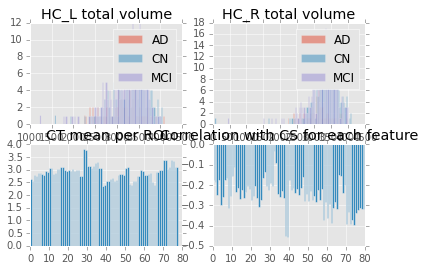

In [34]:
# QC plots
n_feat = X.shape[1]
print X.shape

feat_corr  = []
for col in np.arange(n_feat):
    feat_corr.append(stats.pearsonr(X[:,col],y)[0])

print 'L_HC corr: {}, R_HC_corr: {}'.format(feat_corr[0],feat_corr[1]) 
print 'HC Correlation in each fold'
fid = 1
for train_index, test_index in kf:    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    train_L_HC_vol_mean = np.mean(X_train[:,0])
    train_L_HC_vol_std = np.std(X_train[:,0])
    train_R_HC_vol_mean = np.mean(X_train[:,1])
    train_R_HC_vol_std = np.std(X_train[:,1])
    
    test_L_HC_vol_mean = np.mean(X_test[:,0])
    test_L_HC_vol_std = np.std(X_test[:,0])
    test_R_HC_vol_mean = np.mean(X_test[:,1])
    test_R_HC_vol_std = np.std(X_test[:,1])
    
    train_L_HC_corr = stats.pearsonr(X_train[:,0],y_train)[0]
    train_R_HC_corr = stats.pearsonr(X_train[:,1],y_train)[0]
    test_L_HC_corr = stats.pearsonr(X_test[:,0],y_test)[0]
    test_R_HC_corr = stats.pearsonr(X_test[:,1],y_test)[0]
    print fid
    fid+=1
    print 'test L_HC vol, std, corr: {}, {}, {}'.format(test_L_HC_vol_mean,test_L_HC_vol_std,test_L_HC_corr)
    print 'test R_HC vol, std, corr: {}, {}, {}'.format(test_R_HC_vol_mean,test_R_HC_vol_std,test_R_HC_corr)
    print 'train L_HC vol, std, corr: {}, {}, {}'.format(train_L_HC_vol_mean,train_L_HC_vol_std,train_L_HC_corr)
    print 'train R_HC vol, std, corr: {}, {}, {}'.format(train_R_HC_vol_mean,train_R_HC_vol_std,train_R_HC_corr)

alpha = 0.5
plt.figure()
plt.subplot(2,2,1)
plt.title('HC_L total volume')
plt.hist(X[y_dx_int==0,0],bins=100,alpha=alpha,label='AD')
plt.hist(X[y_dx_int==1,0],bins=100,alpha=alpha,label='CN')
plt.hist(X[y_dx_int==2,0],bins=100,alpha=alpha,label='MCI')
plt.legend()
plt.subplot(2,2,2)
plt.title('HC_R total volume')
plt.hist(X[y_dx_int==0,1],bins=100,alpha=alpha,label='AD')
plt.hist(X[y_dx_int==1,1],bins=100,alpha=alpha,label='CN')
plt.hist(X[y_dx_int==2,1],bins=100,alpha=alpha,label='MCI')
plt.legend()
plt.subplot(2,2,3)
plt.title('CT mean per ROI')
plt.bar(np.arange(n_feat-2),np.mean(X[:,2:],axis=0))
plt.subplot(2,2,4)
plt.title('Correlation with CS for each feature')
plt.bar(np.arange(n_feat),feat_corr)

In [35]:
# Configs for K-fold validations (nested)
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import grid_search
import datetime
import time
import collections
from scipy.stats import mode
from sklearn.metrics import mean_squared_error as mse
import ipyparallel as ipp
from sklearn import preprocessing
from sklearn.cross_validation import KFold
import pickle
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [40]:
#Pick model with its configs/hyper-params
model_list = ['LR_L1', 'SVR', 'RFR']
model_choice_id = 2
model_choice = model_list[model_choice_id]
modality = 'HC_CT'

if model_choice == 'LR_L1':
    model_clf = Lasso()
    hyper_params = {'alpha':[0.2, 0.1, 0.05, 0.01]} 
    scale_data = True #Scales HC and CT features
    inner_loop = True #only needed to optimize hyper-params
    feat_imp = True    
        
elif model_choice == 'SVR':
    model_clf = SVR()
    hyper_params = {'kernel':['linear','rbf'], 'C':[1,10,25]}
    scale_data = True #Scales HC and CT features
    inner_loop = True #only needed to optimize hyper-params
    feat_imp = True
           
elif model_choice == 'RFR':
    model_clf = RandomForestRegressor(n_jobs=6)
    hyper_params = {'n_estimators':[10,50,100,200],'min_samples_split':[2,4,8]}
    #hyper_params = {'min_samples_split':[2,4,8,16]}
    scale_data = False
    inner_loop = True #only needed to optimize hyper-params
    feat_imp = True   
    
else:
    print "Unknown model choice"

In [41]:
# Train and Test models
from functools import partial #Parallelize!!! 

# Load save experimental setup
cohort = 'ADNI2'
exp_setup_path = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/CV_Exp5_{}_ADAS13.pkl'.format(cohort)
exp_setup = pickle.load( open(exp_setup_path, "rb" ) )

X_raw = exp_setup['X']

if modality == 'HC_CT':
    X_modality = X_raw
elif modality == 'HC':
    X_modality = X_raw[:,:2]
elif modality == 'CT':
    X_modality = X_raw[:,2:]
else:
    print "Wrong modality selected..."
    
if scale_data:
    X = preprocessing.scale(X_modality)
else:
    X = X_modality

print 'X shape {}'.format(X.shape)

y = exp_setup['y']
kf = exp_setup['kf']
exp_name = exp_setup['exp_name']

#Some paths to store models and performance stats
CV_model_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/output/'
saved_model_name =''
save_model_path = CV_model_dir + exp_name + '_' + model_choice
load_model_path = CV_model_dir + saved_model_name

# train a new classifer? Or load a single pretrained classifier based on most frequent hyperparams found previously?
# This will NOT load K different classifiers each for outer-CV fold  
train_clf = True
save_model = False #do you really want to save all classifiers per each fold? (default false) 

if train_clf:
    # Create list of all the fold-subsets (needed for parallelization)
    X_train = []
    X_valid = []
    y_train = []
    y_valid = []    
    for train, valid in kf:        
        X_train.append(X[train])
        X_valid.append(X[valid])
        y_train.append(y[train])
        y_valid.append(y[valid])

    CV_r_train=[] #pearson r score for each outer fold on train set
    CV_r_valid=[] #pearson r score for each outer fold on validation set

    CV_R2_train=[] #R2 score for each outer fold on train set
    CV_R2_valid=[] #R2 score for each outer fold on validation set

    CV_MSE_train=[] #MSE for each outer fold on train set
    CV_MSE_valid=[] #MSE for each outer fold on validation set
    
    predicted_CV_scores = []
    actual_CV_scores = []
    
    # Parallization configs for ipython notebook cluster    
    rc = ipp.Client()
    dview = rc[:]
    dview.push(dict(computeOuterFold = computeOuterFold))
    dview.push(dict(innerCVLoop = innerCVLoop))
    mapfunc = partial(computeOuterFold, model_clf=model_clf, hyper_params=hyper_params, inner_loop=inner_loop, 
                  save_model=save_model, save_model_path=save_model_path)
    parallel_result = dview.map_sync(mapfunc, X_train, y_train, X_valid, y_valid)    
    
    hp_dict = collections.defaultdict(list)
    for pr in parallel_result:
        CV_r_train.append(pr['r_train'])
        CV_r_valid.append(pr['r_valid'])
        CV_R2_train.append(pr['R2_train'])
        CV_R2_valid.append(pr['R2_valid'])
        CV_MSE_train.append(pr['MSE_train'])
        CV_MSE_valid.append(pr['MSE_valid'])
        predicted_CV_scores.append(pr['predicted_fold_score'])
        actual_CV_scores.append(pr['actual_fold_scores'])
        
        for hp in hyper_params:
            hp_dict[hp].append(pr['hp_dict'][hp])
            
    #Find out most frequent hyper-params during cross-val    
    hp_mode = {}
    for hp in hyper_params:
        hp_mode[hp] = mode(hp_dict[hp])[0][0]

    print 'most frequent hp:' + str(hp_mode)
    
else: 
    #Grabs the best classifer as a result of N-fold nested CV along with the MSE and R2 stats of the outerloop
    print "Loading previously saved model: "
    f = open(load_model_path)
    result = pickle.load(f)
    test_clf = result['best_clf']
    CV_r_valid = result['CV_r']
    CV_R2_valid = result['CV_R2']
    CV_MSE_valid = result['CV_MSE']
    f.close()

print 'CV r (mean, median, std_err): ' + '{:04.2f},{:04.2f},{:04.2f}'.format(np.mean(zip(*CV_r_valid)[0]),np.median(zip(*CV_r_valid)[0]),stats.sem(zip(*CV_r_valid)[0]))
print 'CV R2 (mean, median, std_err): ' + '{:04.2f},{:04.2f}, {:04.2f}'.format(np.mean(CV_R2_valid),np.median(CV_R2_valid),stats.sem(CV_R2_valid))
print 'CV MSE (mean, median, std_err): ' + '{:04.2f},{:04.2f}, {:04.2f}'.format(np.mean(CV_MSE_valid),np.median(CV_MSE_valid),stats.sem(CV_MSE_valid))

X shape (587, 80)
most frequent hp:{'n_estimators': array([100]), 'min_samples_split': array([2])}
CV r (mean, median, std_err): 0.57,0.58,0.03
CV R2 (mean, median, std_err): 0.32,0.31, 0.03
CV MSE (mean, median, std_err): 66.61,67.49, 4.94


In [ ]:
# check feature importance (QC for HC importance)
# for fid in np.arange(10):
#     model_clf.fit(X_train[fid],y_train[fid])
#     feat_imp = model_clf.feature_importances_
#     print 
#     print 'fid: {} r: {}'.format(fid, zip(*CV_r_valid)[0][fid])
#     print feat_imp[70:], np.argsort(feat_imp)[70:]
print zip(*CV_r_valid)[0]


In [ ]:
Baseline LR
(0.67967240054210754, 0.56879797495184137, 0.5988231662490886, 0.49284028165514948, 0.44557890444609999, 
 0.47786003640429192, 0.46596289072680858, 0.57504122653514778, 0.50115343570863291, 0.39597569280487466)

Baseline SVM
(0.62237892217611546, 0.57901237913619108, 0.5995505148783985, 0.63809749144729178, 0.50999802815791628, 
 0.41846572003796645, 0.51909135695525321, 0.53601265150967115, 0.62202899109905141, 0.46246681135277817)

Baseline RF
(0.63730326194822251, 0.5480008167500251, 0.5979178178622252, 0.6345268923559243, 0.50666992310274372, 
 0.42995872752093789, 0.51865025005439525, 0.54964129730024791, 0.62336378651955171, 0.48022963536921681)

Benchmark: 
    
X shape (680, 80)
most frequent hp:{'n_estimators': array([200]), 'min_samples_split': array([8])}
CV r (mean, median, std_err): 0.55,0.55,0.02
CV R2 (mean, median, std_err): 0.30,0.28, 0.02
CV MSE (mean, median, std_err): 56.87,50.27, 4.55

#LR_L1
---Pilot------
most frequent hp:{'alpha': array([ 0.2])}
CV r (mean, median, std_err): 0.55,0.57,0.02
CV R2 (mean, median, std_err): 0.29,0.29, 0.03
CV MSE (mean, median, std_err): 57.22,52.11, 4.19        
    
---Exp3------
CT: X shape (716, 78)
most frequent hp:{'alpha': array([ 0.2])}
CV r (mean, median, std_err): 0.57,0.55,0.02
CV R2 (mean, median, std_err): 0.31,0.29, 0.02
CV MSE (mean, median, std_err): 57.78,54.68, 3.50
    
HC_CT: X shape (716, 80)
most frequent hp:{'alpha': array([ 0.2])}
CV r (mean, median, std_err): 0.57,0.56,0.02
CV R2 (mean, median, std_err): 0.31,0.30, 0.02
CV MSE (mean, median, std_err): 57.27,54.46, 3.47


#SVM
---Pilot------
most frequent hp:{'kernel': array(['rbf'], 
      dtype='|S3'), 'C': array([10])}
CV r (mean, median, std_err): 0.53,0.51,0.03
CV R2 (mean, median, std_err): 0.26,0.23, 0.04
CV MSE (mean, median, std_err): 59.88,55.64, 5.08
#RF
---Pilot------
most frequent hp:{'n_estimators': array([100]), 'min_samples_split': array([4])}
CV r (mean, median, std_err): 0.56,0.58,0.02
CV R2 (mean, median, std_err): 0.30,0.31, 0.03
CV MSE (mean, median, std_err): 57.05,51.99, 4.91


In [21]:
# Compute single model from the most frequent hyper-params (for across dataset testing)

#test_clf = Lasso(alpha=0.2)    
#test_clf = SVR(kernel='rbf',C=25)
test_clf = RandomForestRegressor(n_estimators=200,min_samples_split=4,n_jobs=4)

save_CV_perf = True    
if save_CV_perf:
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
    save_model_filename = save_model_path + '_' + modality + '_' + st + '.pkl'
    classifier_model_and_stats = {'best_clf':test_clf, 'CV_R2':CV_R2_valid, 'CV_MSE':CV_MSE_valid, 'CV_r': CV_r_valid,
                                 'predicted_CV_scores':predicted_CV_scores,'actual_CV_scores':actual_CV_scores}
    pickleIt(classifier_model_and_stats,save_model_filename)


In [ ]:
# Plotting stuff...
boxplot_config_r = collections.defaultdict(list)
boxplot_config_R2 = collections.defaultdict(list)
boxplot_config_MSE = collections.defaultdict(list)
boxplots_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/output/'
scale = 'ADAS13'
if scale == 'ADAS13':
    baseline_models = {'LR_HC*':'Exp4_ADNI1_ADAS13_LR_L1_HC_2016-02-29-15-16-45.pkl',
                       'LR_CT*':'Exp4_ADNI1_ADAS13_LR_L1_CT_2016-02-29-15-17-13.pkl',
                       'LR_HC_CT*': 'Exp4_ADNI1_ADAS13_LR_L1_HC_CT_2016-02-29-15-17-50.pkl',
                       'SVR_HC*':'Exp4_ADNI1_ADAS13_SVR_HC_2016-02-29-15-11-52.pkl',
                       'SVR_CT*':'Exp4_ADNI1_ADAS13_SVR_CT_2016-02-29-15-14-09.pkl',
                       'SVR_HC_CT*':'Exp4_ADNI1_ADAS13_SVR_HC_CT_2016-02-29-15-16-22.pkl', 
                       'RFR_HC':'Exp4_ADNI1_ADAS13_RFR_HC_2016-02-29-15-19-26.pkl',
                       'RFR_CT':'Exp4_ADNI1_ADAS13_RFR_CT_2016-02-29-15-21-25.pkl',
                       'RFR_HC_CT':'Exp4_ADNI1_ADAS13_RFR_HC_CT_2016-02-29-15-24-23.pkl'}
if scale == 'MMSE':
    baseline_models = {'LR_L1*': 'LR_L1_MMSE_2015-12-29-16-41-41.pkl',
                    'SVR*':'RFR_MMSE_2015-12-29-17-35-51.pkl', 
                    'RFR':'SVR_MMSE_2015-12-29-17-40-24.pkl'}

# Not plotted:
# 'LR_L1': 'LR_L1_ADAS13_2015-11-06-12-25-21.pkl'
# 'LR_L1_infl':'LR_L1_ADAS13_inflated_train_parallel_2015-11-27-15-05-17.pkl'
r_means =  collections.defaultdict(list)    
r_medians =  collections.defaultdict(list)    
r_sems =  collections.defaultdict(list)
mse_means =  collections.defaultdict(list)        
mse_medians =  collections.defaultdict(list)        
mse_sems =  collections.defaultdict(list)
predicted_CV_scores = collections.defaultdict(list) 
actual_CV_scores = collections.defaultdict(list)
keys_used = []
for key,val in baseline_models.iteritems():
    pkl_file = open(boxplots_dir + val, 'rb')
    saved_data = pickle.load(pkl_file)
    pkl_file.close()            
    boxplot_config_r[key].append(zip(*saved_data['CV_r'])[0])
    boxplot_config_MSE[key].append(saved_data['CV_MSE'])
    print 'key: {}, mean: {}, median: {}, std: {}'.format(key,np.mean(zip(*saved_data['CV_r'])[0]),
                                              np.median(zip(*saved_data['CV_r'])[0]),
                                              np.std(zip(*saved_data['CV_r'])[0]))
    r_means[key].append(np.mean(zip(*saved_data['CV_r'])[0]))
    r_medians[key].append(np.median(zip(*saved_data['CV_r'])[0]))
    r_sems[key].append(stats.sem(zip(*saved_data['CV_r'])[0]))        

    mse_means[key].append(np.mean(saved_data['CV_MSE']))
    mse_sems[key].append(stats.sem(saved_data['CV_MSE']))        
    if key in ['LR_HC_CT*','SVR_HC_CT*','RFR_HC_CT']:
        predicted_CV_scores[key].append(saved_data['predicted_CV_scores'])
        actual_CV_scores[key].append(saved_data['actual_CV_scores'])

# Since ANN model perfs are saved differently :-/
boxplots_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/'
ANN_models ={'CT':'Exp4_ADNI1_ADAS13_NN_CT_2016-03-03-21-54-55.pkl',
             'HC':'Exp4_ADNI1_ADAS13_NN_HC_2016-03-04-00-24-38.pkl',
             'HC_CT':'Exp4_ADNI1_ADAS13_NN_HC_CT_2016-03-03-14-34-34.pkl'}

for key,val in ANN_models.iteritems():
    pkl_file = open(boxplots_dir + val, 'rb')
    saved_data = pickle.load(pkl_file)               
    boxplot_config_r['ANN_'+key].append(saved_data['CV_r'])
    boxplot_config_MSE['ANN_'+key].append(saved_data['CV_MSE'])
    pkl_file.close()
    print 'key: {}, mean: {}, median: {}, std: {}'.format(key,np.mean(saved_data['CV_r']),
                                              np.median(saved_data['CV_r']),
                                              np.std(saved_data['CV_r']))
    r_means['ANN_'+key].append(np.mean(saved_data['CV_r']))
    r_sems['ANN_'+key].append(stats.sem(saved_data['CV_r']))

    mse_means['ANN_'+key].append(np.mean(saved_data['CV_MSE']))
    mse_sems['ANN_'+key].append(stats.sem(saved_data['CV_MSE']))
    if key == 'HC_CT':
        predicted_CV_scores['ANN_' + key].append(saved_data['predicted_CV_scores'])
        actual_CV_scores['ANN_' + key].append(saved_data['actual_CV_scores'])

print zip(r_means, r_sems)

In [ ]:
#plot foldwise results
plt.rcParams['figure.figsize'] = (20, 10)
fids = np.arange(1,11,1)
print boxplot_config_r.keys()
for key in boxplot_config_r.keys():
    if key in ['ANN_CT','ANN_HC','ANN_HC_CT']:
        custom_marker = 'd'    
    else:
        custom_marker = 'o'
    plt.subplot(2,1,1)
    plt.plot(fids,boxplot_config_r[key][0],linestyle='None',marker=custom_marker,label=key)
    plt.legend(bbox_to_anchor=[0.5, -0.1], loc='center', ncol=6)    
    plt.xlim(0,11)

    plt.subplot(2,1,2)
    plt.plot(fids,boxplot_config_MSE[key][0],linestyle='None',marker=custom_marker,label=key)
    plt.legend(bbox_to_anchor=[0.5, -0.1], loc='center', ncol=6)
    plt.xlim(0,11)


modality = 'ANN_HC_CT'
    
print 'corr: {}:{}'.format(modality,boxplot_config_r[modality][0][4:8])
print 'MSE: {}:{}'.format(modality,boxplot_config_MSE[modality][0][4:8])


In [ ]:
# Boxplots for CV statistics (r, mse, R2)
stat_measure_list = [boxplot_config_r,boxplot_config_MSE] #boxplot_config_MSE
stat_measure_names = ['Pearson r', 'RMSE'] #'MSE'
from matplotlib.artist import setp
font_small = 25
font_med = 30
font_large = 40
plt.rcParams['figure.figsize'] = (40, 40)
#custom_cols = ['LR_L1*','LR_L1_infl*', 'SVR*', 'SVR_infl*', 'RFR', 'RFR_infl','ANN_HC_CT']
custom_cols = ['LR_HC*','LR_CT*','LR_HC_CT*','SVR_HC*','SVR_CT*','SVR_HC_CT*','RFR_HC','RFR_CT','RFR_HC_CT',
               'ANN_HC','ANN_CT','ANN_HC_CT']
boxplot = False
errorbarplot = True
scatterplot = True

my_colors = ['steelblue', 'olivedrab', 'cadetblue', 'salmon']
#plt.figure()
ax1 = plt.subplot2grid((6,2), (0,0), colspan=2,rowspan=2)
ax2 = plt.subplot2grid((6,2), (2,0), colspan=2,rowspan=2)
ax3 = plt.subplot2grid((6,2), (4,0))
ax4 = plt.subplot2grid((6,2), (4,1))
ax5 = plt.subplot2grid((6,2), (5,0))
ax6 = plt.subplot2grid((6,2), (5,1))

ax_list = [ax1,ax2,ax3,ax4,ax5,ax6]

if errorbarplot:
    custom_r_means = []    
    custom_r_sems = []    
    custom_mse_means = []
    custom_mse_sems = []
    for c, col in enumerate(custom_cols):
        custom_r_means.append(r_means[col][0])        
        custom_r_sems.append(r_sems[col][0])
        custom_mse_means.append(mse_means[col][0])        
        custom_mse_sems.append(mse_sems[col][0])
        
    x_r = np.array([0,1,2,4,5,6,8,9,10,12,13,14])  # padding to better appearance 
    x_mse = x_r 
    #plt.bar(x, np.array(custom_r_means), yerr=np.array(custom_r_sems))
    width = 0.25                    # bar width

    #fig, ax = plt.subplots()
    plot_corr = True
    if plot_corr: 

        rects1 = ax1.bar(x_r[:3], custom_r_means[:3],                  # data
                        width,                          # bar width
                        color=my_colors[0],        # bar colour
                        yerr=custom_r_sems[:3],               # data for error bars
                        error_kw={'ecolor':'darkslategrey',    # error-bars colour
                                 'linewidth':4},       # error-bar width
                        label = 'Linear Regression')

        rects2 = ax1.bar(x_r[3:6], custom_r_means[3:6],                  # data
                        width,                          # bar width
                        color=my_colors[1],        # bar colour
                        yerr=custom_r_sems[3:6],               # data for error bars
                        error_kw={'ecolor':'darkslategrey',    # error-bars colour
                                 'linewidth':4},
                        label = 'Support Vector Regression')

        rects3 = ax1.bar(x_r[6:9], custom_r_means[6:9],                  # data
                        width,                          # bar width
                        color=my_colors[2],        # bar colour
                        yerr=custom_r_sems[6:9],               # data for error bars
                        error_kw={'ecolor':'darkslategrey',    # error-bars colour
                                 'linewidth':4},
                         label = 'Random Forest')

        rects4 = ax1.bar(x_r[9:], custom_r_means[9:],                  # data
                        width,                          # bar width
                        color=my_colors[3],        # bar colour
                        yerr=custom_r_sems[9:],               # data for error bars
                        error_kw={'ecolor':'darkslategrey',    # error-bars colour
                                 'linewidth':4},
                        label = 'Artificial Neural Network')
        autolabel(rects1,ax1)
        autolabel(rects2,ax1)
        autolabel(rects3,ax1)
        autolabel(rects4,ax1)
        #Plot annotations 
        ax1.set_ylabel('Correlation',fontsize=font_large)
        ax1.set_xlim(-0.5,max(x_r)+1)
        ax1.set_ylim(0,1)
        ax1.set_xticks(x_r)
        ax1.set_xticklabels(custom_cols)
        ax1.tick_params(labelsize=font_small)
        #ax1.set_yticks(fontsize=font_med)
        ax1.legend(fontsize=font_med, loc=2)
    
    plot_mse = True
    if plot_mse: 
        rects5 = ax2.bar(x_mse[:3], custom_mse_means[:3],                  # data
                        width,                          # bar width
                        color=my_colors[0],        # bar colour
                        yerr=custom_mse_sems[:3],               # data for error bars
                        error_kw={'ecolor':'darkslategrey',    # error-bars colour
                                 'linewidth':4})

        rects6 = ax2.bar(x_mse[3:6], custom_mse_means[3:6],                  # data
                        width,                          # bar width
                        color=my_colors[1],        # bar colour
                        yerr=custom_mse_sems[3:6],               # data for error bars
                        error_kw={'ecolor':'darkslategrey',    # error-bars colour
                                 'linewidth':4})

        rects7 = ax2.bar(x_mse[6:9], custom_mse_means[6:9],                  # data
                        width,                          # bar width
                        color=my_colors[2],        # bar colour
                        yerr=custom_mse_sems[6:9],               # data for error bars
                        error_kw={'ecolor':'darkslategrey',    # error-bars colour
                                 'linewidth':4})

        rects8 = ax2.bar(x_mse[9:], custom_mse_means[9:],                  # data
                        width,                          # bar width
                        color=my_colors[3],        # bar colour
                        yerr=custom_mse_sems[9:],               # data for error bars
                        error_kw={'ecolor':'darkslategrey',    # error-bars colour
                                 'linewidth':4})
        autolabel(rects5,ax2)
        autolabel(rects6,ax2)
        autolabel(rects7,ax2)
        autolabel(rects8,ax2)

        #Plot annotations 
        ax2.set_ylabel('MSE',fontsize=font_large)
        ax2.set_xlim(-0.5,max(x_r)+1)
        ax2.set_ylim(0,100)
        ax2.set_xticks(x_r)
        ax2.set_xticklabels(custom_cols)
        ax2.tick_params(labelsize=font_small)
        #ax1.set_yticks(fontsize=font_med)
        ax2.legend(fontsize=font_med, loc=2)
    
if scatterplot:
    #plt.figure()
    
    for k, key in enumerate(['LR_HC_CT*','SVR_HC_CT*', 'RFR_HC_CT', 'ANN_HC_CT']):
        x = np.hstack(actual_CV_scores[key][0])
        y = np.hstack(predicted_CV_scores[key][0])
        ax_offset = 2
        #plt.subplot(2,2,k+1)
        ax_list[k+ax_offset].scatter(x, y, c=my_colors[k], s=40)
        fit = np.polyfit(x,y,1)
        fit_fn = np.poly1d(fit) 
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        if p_value < 0.0001:
            p_value_sig = '<0.0001'
        else:
            p_value_sig = str(p_value)

        #Plot annotations
        label_str = 'model: {}'.format(key) + '\n' + 'r-value: {:04.2f}'.format(r_value) + '\n' + 'p-value: ' + p_value_sig + '\n' + 'std_err: {:04.2f}'.format(std_err) 
        # fit_fn is now a function which takes in x and returns an estimate for y
        ax_list[k+ax_offset].plot(x, fit_fn(x),linewidth=3, c=my_colors[k], label=label_str)
        #plt.title(model_choice,fontsize=font_large)
        ax_list[k+ax_offset].set_ylim(0,40)
        ax_list[k+ax_offset].set_xlabel('Actual Score',fontsize=font_large)
        ax_list[k+ax_offset].set_ylabel('Predicted Score',fontsize=font_large)            
        ax_list[k+ax_offset].legend(fontsize=font_small,loc=2)
        ax_list[k+ax_offset].tick_params(labelsize=font_med)

#Save figure
save_fig = False
if save_fig:
    box_fig = plt.gcf()
    box_fig.savefig('{}Exp4_ADNI1_ADAS13_PerfPlots.png'.format(boxplots_dir), bbox_inches='tight')

In [32]:
# Some Defs
def pickleIt(my_data,save_path):
    f = open(save_path, 'wb')
    pickle.dump(my_data, f)
    f.close()

#Outer Fold Computation (need the imports inside def if you want to parallelize!)
def computeOuterFold(train_X, train_y, valid_X, valid_y, model_clf, hyper_params, inner_loop, save_model, save_model_path):
    import collections
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import grid_search
    import datetime
    import time
    import collections
    from scipy.stats import mode
    from sklearn.metrics import mean_squared_error as mse
    from scipy import stats
    
    print 'Starting Outerfold computation'
    
    hp_dict = collections.defaultdict(list) #store best hyper-parameters for each fold
    
    if inner_loop:     
        print 'Starting InnerFold computation'
        save_model_path_fold = save_model_path + '_fold_' 
        clf = innerCVLoop(model_clf,hyper_params,train_X, train_y,save_model,save_model_path_fold)
        for hp in hyper_params:
            hp_dict[hp].append(clf.best_estimator_.get_params()[hp])
            
        print 'Ending InnerFold computation'

    else:
        clf = model_clf
        clf.fit(fold_X,fold_y)
        
    #CV_scores    
    r_train = stats.pearsonr(clf.predict(train_X),train_y)
    r_valid = stats.pearsonr(clf.predict(valid_X),valid_y)
        
    R2_train = clf.score(train_X,train_y) 
    R2_valid = clf.score(valid_X,valid_y)
        
    MSE_train = mse(clf.predict(train_X),train_y)
    MSE_valid = mse(clf.predict(valid_X),valid_y)
    
    print 'Ending OuterFold computation'
    
    return {'r_train':r_train, 'r_valid':r_valid, 'R2_train':R2_train, 'R2_valid':R2_valid,
            'MSE_train':MSE_train, 'MSE_valid':MSE_valid, 'hp_dict':hp_dict, 
            'predicted_fold_score': clf.predict(valid_X), 'actual_fold_scores':valid_y}

#Inner Fold Computation (need the imports inside def if you want to parallelize!)
def innerCVLoop(model_clf,hyper_params,fold_X, fold_y,save_model,save_model_path):
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import grid_search
    clf = grid_search.GridSearchCV(model_clf, hyper_params,cv=3,verbose=0)
    clf.fit(fold_X, fold_y)
    #Save classifier
    if save_model:
        save_model(clf,save_model_path)
        
    return clf

def autolabel(rects,_ax):
    for rect in rects:
        height = rect.get_height()
        _ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '{:03.2f}'.format(height),
                ha='center',            # vertical alignment
                va='bottom',             # horizontal alignment
                fontsize = 25)


In [ ]:
matches = [x for x in y_dx if x == 'No_DX']
print matches

In [ ]:
CS_vals = sub_CS_dict_clean.values()
plt.hist(CS_vals)

In [43]:
cohort = 'ADNI2'
exp_setup_path = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/CV_Exp5_{}_ADAS13.pkl'.format(cohort)
exp_setup = pickle.load( open(exp_setup_path, "rb" ) )
kf = exp_setup['kf']
adni2_sub_list = exp_setup['common_subs']

In [47]:
common_keys = list(set(adni1_sub_list) & set(adni2_sub_list))
print len(adni1_sub_list), len(adni2_sub_list)
print common_keys
                

777 587
[]
